In [2]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import ast

In [3]:

def read_graph_from_gml(file, draw=False):
    G = nx.read_gml(file)
#     file_name = file[0:-4]
#     if file_name == 'Surfnet':
#         # The Dutch Topology Zoo dataset
#         end_node_list = ["Middelburg", "Groningen", "Maastricht", "Enschede", "Delft", "Amsterdam", "Utrecht", "Den_Helder"]
#     elif file_name == "SurfnetFiberdata":
#         end_node_list = ["Asd001b", "Mt001a", "GN001A", "DT001A"]
#     elif file_name == "SurfnetCore":
#         end_node_list = ["Amsterdam 1", "Delft 1", "Groningen 1", "Maastricht", "Enschede 2"]
#     elif file_name == 'Colt':
#         # The European Topology Zoo dataset
#         # Use QIA members: IQOQI, UOI (Innsbruck), CNRS (Paris), ICFO (Barcelona), IT (Lisbon),
#         #              MPQ (Garching [DE] -> Munich), NBI (Copenhagen), QuTech (Delft -> The Hague), UOB (Basel),
#         #              UOG (Geneva)
#         # NOTE: Graching replaced by Munich, Delft by The Hague
#         end_node_list = ['Innsbruck', 'Paris', 'Barcelona', 'Lisbon', 'Copenhagen', 'TheHague', 'Basel', 'Geneva',
#                          'Stuttgart']
#     else:
#         raise NotImplementedError("Dataset {} not implemented (no city list defined)".format(file_name))
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
#         if node in end_node_list:
#             nodedata['type'] = 'end_node'
#         else:
        nodedata['type'] = 'repeater_node'
    nx.set_node_attributes(G, pos, name='pos')
    if draw:
        draw_graph(G)
    return G

# def compute_dist_lat_lon(graph):
def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
#     dist = []
#     for edge in graph.edges():
    node1, node2 = edge
#         print(node1,node2)
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         dist.append(np.round(R * c, 5))
    return np.round(R * c, 5)

def draw_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    repeater_nodes = []
    end_nodes = []
    for node in G.nodes():
        if G.nodes[node]['type'] == 'repeater_node':
            repeater_nodes.append(node)
        else:
            end_nodes.append(node)
    fig, ax = plt.subplots(figsize=(7, 7))
    end_nodes = nx.draw_networkx_nodes(G=G, pos=pos, nodelist=end_nodes, node_shape='s', node_size=1500,
                                       node_color=[[1.0, 120 / 255, 0.]], label="End Node", linewidths=3)
#     end_nodes.set_edgecolor('K')
    rep_nodes = nx.draw_networkx_nodes(G=G, pos=pos, nodelist=repeater_nodes, node_size=50,
                                       node_color=[[1, 1, 1]], label="Repeater Node")
    rep_nodes.set_edgecolor('black')
    end_node_labels = {}
    repeater_node_labels = {}
    for node, nodedata in G.nodes.items():
        # labels[node] = node
        if G.nodes[node]['type'] == 'end_node':  # or node in self.repeater_nodes_chosen:
            end_node_labels[node] = node
        else:
            repeater_node_labels[node] = node
    nx.draw_networkx_labels(G=G, pos=pos, labels=end_node_labels, font_size=30, font_weight="bold", font_color="w",
                            font_family='serif')
#     nx.draw_networkx_labels(G=G, pos=pos, labels=repeater_node_labels, font_size=30, font_weight="bold")
    nx.draw_networkx_edges(G=G, pos=pos, width=1)
    plt.axis('off')
    margin = 0.33
    fig.subplots_adjust(margin, margin, 1. - margin, 1. - margin)
    ax.axis('equal')
    fig.tight_layout()
    plt.show()

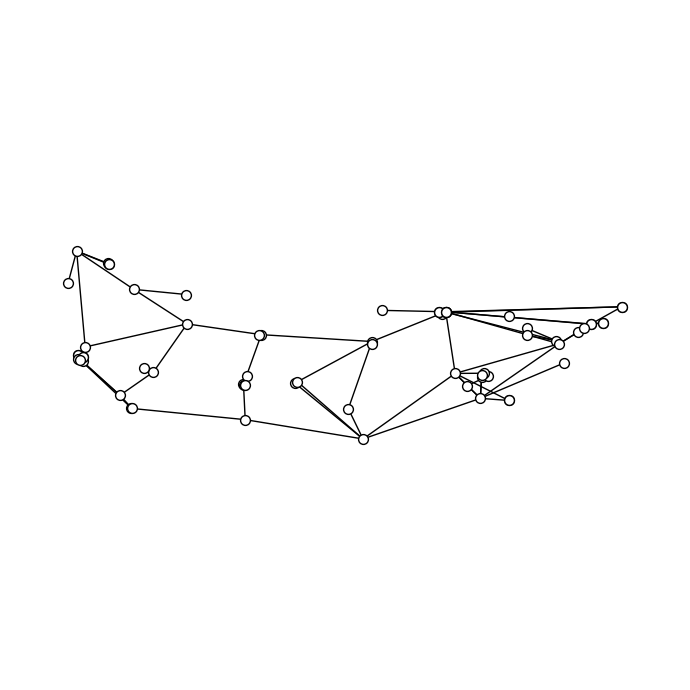

In [4]:
f_dir = "gml_files/"
# G = read_graph_from_gml(f_dir+"SurfnetCore.gml", draw=False)
# G = read_graph_from_gml(f_dir+"SurfnetFiberdata.gml", draw=False)
G = read_graph_from_gml(f_dir+"ESnet2.gml", draw=True)
# pos = nx.get_node_attributes(G, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=True, font_size=6, pos=pos)


AxisError: axis -1 is out of bounds for array of dimension 0

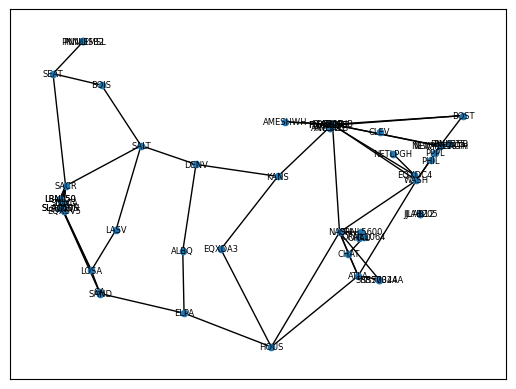

<Figure size 640x480 with 0 Axes>

In [55]:
gml_file = open(f_dir+"ESnet2.gml", "w")
gml_file.write("graph [\n")
gml_file.write("  DateObtained \"07/17/23\"\n")
# gml_file.write("  From https://github.com/esnet/grafana-esnet-networkmap-panel/blob/705588882d02eee75965052f91907418c593275f/index.html \n")
gml_file.write("  GeoLocation \"USA\"\n")

file = open(f_dir+ 'ESnet_nodes.txt', mode = 'r')#, encoding = 'utf-8-sig')
lines = file.readlines()
text_length = 5
N_sites= int(len(lines)/text_length)
# print(N_sites)
site_ids = dict()
counter = 0
for i in range(N_sites):
# i = 0
#     print(lines[5*i+1][12:] + "  "+ lines[5*i+3][14:])
# print(lines[5*i+1].replace("\"", '').replace(",", '')[9:])
    station = lines[text_length*i+1].split(':')[1].replace(",", '').replace("\n", '').replace(" ", '')
    columns = [item.strip() for item in lines[text_length*i+3][14:].replace("[", '').replace("]", '').split(',')]
# print(columns[0],columns[1])
# print(lines[5*i+1][12:] + "  "+ lines[5*i+3][14:])
    if float(columns[1]) < -50: # inside America
        site_ids[station.replace("\"", '')] = counter
        gml_file.write("  node [\n")
        gml_file.write("    id %d\n" % counter)
        gml_file.write("    label "+ station+ "\n")
        gml_file.write("    Country \"United States\"\n")
        gml_file.write("    Longitude "+ columns[1]+ "\n")
        gml_file.write("    Internal 1\n")
        gml_file.write("    Latitude "+ columns[0]+ "\n")
        gml_file.write("  ]\n")
        counter += 1


file = open(f_dir+ 'ESnet_edges.txt', mode = 'r')#, encoding = 'utf-8-sig')
lines = file.readlines()
text_length = 15
N_edges= int(len(lines)/text_length)
# print(N_edges)
counter = 0
for i in range(N_edges):
#     i = 0
    sd_pair = lines[text_length*i+1][12:].replace("\"", '').replace(",", '').replace("\n", '').split('--')
#     print(site_ids[sd_pair[0]],site_ids[sd_pair[1]])
    if sd_pair[0] in site_ids and sd_pair[1] in site_ids:
        gml_file.write("  edge [\n")
        gml_file.write("    source "+ str(site_ids[sd_pair[0]])+ "\n")
        gml_file.write("    target "+ str(site_ids[sd_pair[1]])+ "\n")
        gml_file.write("    start "+ "\"" + str(sd_pair[0])+ "\"" + "\n")
        gml_file.write("    end "+ "\"" + str(sd_pair[1])+ "\""+ "\n")
        gml_file.write("    id e%d\n" % counter)
        gml_file.write("  ]\n")
        counter += 1

# edge [
# source 1
# target 34
# id "e39"
# ]

gml_file.write("]")
gml_file.close()


65 84


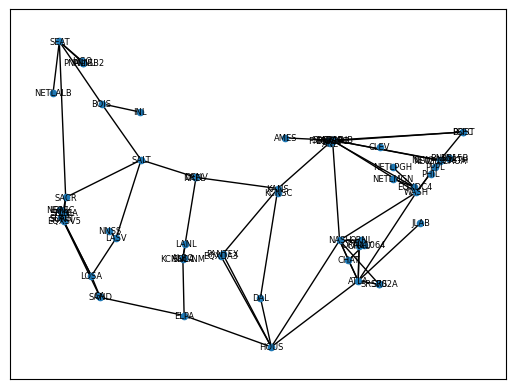

In [5]:

f_dir = "gml_files/"
# G = read_graph_from_gml(f_dir+"SurfnetCore.gml", draw=False)
# G = read_graph_from_gml(f_dir+"SurfnetFiberdata.gml", draw=False)
G = read_graph_from_gml(f_dir+"ESnet2.gml", draw=False)
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=True, font_size=6, pos=pos)

print(len(G.nodes),len(G.edges))

# dist_list = compute_dist_lat_lon(G)
# plt.figure()
# plt.hist(dist_list, bins=20)
# plt.show()
# # G.nodes["ALBQ"]['Latitude']


57 72


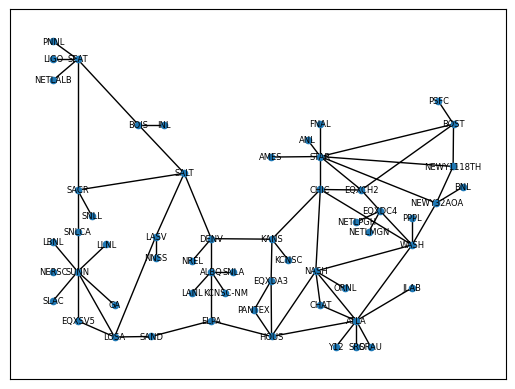

In [25]:
f_dir = "gml_files/"
G_selected = read_graph_from_gml(f_dir+"ESnet3.gml", draw=False)
pos_list = nx.get_node_attributes(G_selected, 'pos')
# print(pos)
for node in pos_list:
#     print(pos_list[node])
    pos_list[node][1] = -pos_list[node][1]
nx.draw_networkx(G=G_selected,  width=1, node_size = 20, with_labels=True, font_size=6, pos=pos_list)
print(len(G_selected.nodes),len(G_selected.edges))

## subset of nodes

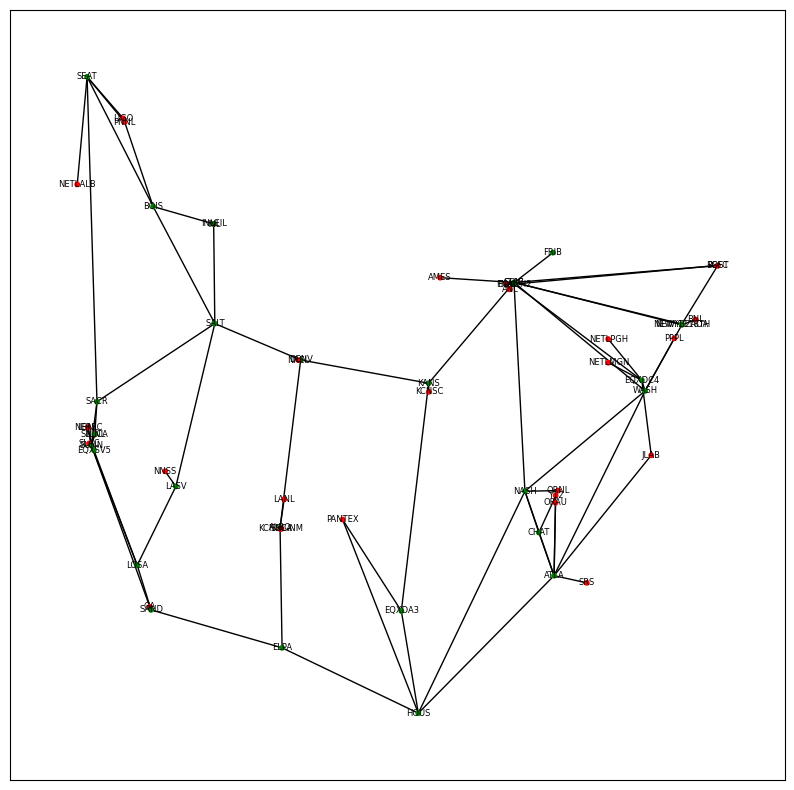

In [31]:

f_dir = "gml_files/"
# G = read_graph_from_gml(f_dir+"SurfnetCore.gml", draw=False)
# G = read_graph_from_gml(f_dir+"SurfnetFiberdata.gml", draw=False)
G = read_graph_from_gml(f_dir+"ESnet2.gml", draw=False)
pos = nx.get_node_attributes(G, 'pos')
# G_new = G.copy()
# for node in G.nodes():
#     if node not in G_selected.nodes():
#         G_new.remove_node(node)
# #         print(node)
    
# for node in G_selected.nodes():
#     if node not in G.nodes():
# #         G_new.remove_node(node)
#         print(node)

# # G_new.remove_node("PANTEX")
  
# for node in G_selected.nodes():
#     if node not in G.nodes():
#         print(node)
        
# nx.draw_networkx(G=G_new,  width=1, node_size = 20, with_labels=True, font_size=6, pos=pos)
# print(len(G_new.nodes),len(G_new.edges))
# dist_list = compute_dist_lat_lon(G)
# plt.figure()
# plt.hist(dist_list, bins=20)
# plt.show()
# G.nodes["ALBQ"]['Latitude']

# orig_edges = np.copy(G_new.edges())
# c_edge = 0
# c_rep = 0
# for edge in orig_edges:
#     dist = compute_dist_lat_lon(edge,G_new)
#     if dist > 300:
#         n1, n2 = edge
#         c_edge += 1
#         n_rep = int(dist/100)
#         G_new.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
#         G_new.add_edge(n1,c_rep)
#         i_r = 0
# #         if c_rep == 0:
# #             print(n1,n2)
# #             print("%d" % (i_r+c_rep))
#         pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
#         G_new.add_edge(c_rep+n_rep-1,n2)
#         i_r = n_rep -1
#         pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
#         for i_r in range(1,n_rep-1):
#             G_new.add_edge(i_r+c_rep,i_r+c_rep+1)
#             pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
#         c_rep += n_rep
# print(c_edge,c_rep)

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
        color_map.append('blue')
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            color_map.append('red')
        else:
            nodedata['type'] = 'router'
            color_map.append('green')

            
# for node in G_new:
#     if type(node)==np.int64:
#         color_map.append('red')
#     else: 
#         color_map.append('blue')      
        
plt.figure(figsize=(10,10))
nx.draw_networkx(G=G,  width=1, node_size = 10, with_labels=True, font_size=6,pos = pos, node_color=color_map)
# print(pos)

In [23]:
from pyvis.network import Network
g = Network(notebook=True)
# populates the nodes and edges data structures

file = open(f_dir+ 'ESnet_nodes.txt', mode = 'r')#, encoding = 'utf-8-sig')
lines = file.readlines()
text_length = 5
N_sites= int(len(lines)/text_length)
site_ids = dict()
counter = 0
for i in range(N_sites):
    station = lines[text_length*i+1].split(':')[1].replace(",", '').replace("\n", '').replace(" ", '')
    columns = [item.strip() for item in lines[text_length*i+3][14:].replace("[", '').replace("]", '').split(',')]
    if float(columns[1]) < -50: # inside America
        site_ids[station.replace("\"", '')] = counter
        g.add_node(counter, value=1, label=station, x=200+float(columns[1]),y=float(columns[0]))        
        counter += 1
# g.add_nodes([1,2,3], value=[10, 100, 400],
#                          title=['I am node 1', 'node 2 here', 'and im node 3'],
#                          x=[21.4, 54.2, 11.2],
#                          y=[100.2, 23.54, 32.1],
#                          label=['NODE 1', 'NODE 2', 'NODE 3'],
#                          color=['#00ff1e', '#162347', '#dd4b39'])


file = open(f_dir+ 'ESnet_edges.txt', mode = 'r')#, encoding = 'utf-8-sig')
lines = file.readlines()
text_length = 15
N_edges= int(len(lines)/text_length)
counter = 0
for i in range(N_edges):
    sd_pair = lines[text_length*i+1][12:].replace("\"", '').replace(",", '').replace("\n", '').split('--')
    if sd_pair[0] in site_ids and sd_pair[1] in site_ids:
        g.add_edge(site_ids[sd_pair[0]],site_ids[sd_pair[1]])
        counter += 1

# nt.from_nx(G)
# nt.show_buttons(filter_=["physics"])
# g.toggle_physics(True)
for n in g.nodes:
    n.update({'physics': False})
g.show('nx.html')

nx.html


In [16]:
g = Network(notebook=True)
g.add_nodes([1, 2, 3],
            value=[1, 1, 1],
            title=["I am node 1", "node 2 here", "and im node 3"],
            x=[0, 100, 100],
            y=[0, 100, 200], label=["NODE 1", "NODE 2", "NODE 3"],
            color=["#00ff1e", "#162347", "#dd4b39"])

g.show('just_nodes.html')

g.add_edge(1, 2)
g.add_edge(1, 3)

g.show('with_edges.html')

for n in g.nodes:
    n.update({'physics': False})

g.show('with_edges_and_physics.html')

just_nodes.html
with_edges.html
with_edges_and_physics.html


In [195]:
# file = open(f_dir+ 'ESnet_edges.txt', mode = 'r')#, encoding = 'utf-8-sig')
# lines = file.readlines()
# text_length = 15
# N_edges= int(len(lines)/text_length)
# # print(N_edges)
# for i in range(N_edges):
# # i = 0
#     sd_pair = lines[text_length*i+1][12:].replace("\"", '').replace(",", '').replace("\n", '').split('--')
#     print(sd_pair)
#     print(site_ids[sd_pair[0]],site_ids[sd_pair[1]])


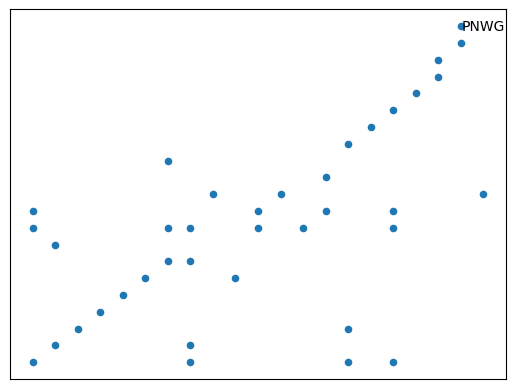

In [217]:
gml_file = open(f_dir+"ESnet_pretty.gml", "w")
gml_file.write("graph [\n")
gml_file.write("  DateObtained \"07/17/23\"\n")
# gml_file.write("  From https://github.com/esnet/grafana-esnet-networkmap-panel/blob/705588882d02eee75965052f91907418c593275f/index.html \n")
gml_file.write("  GeoLocation \"USA\"\n")

file = open(f_dir+ 'ESnet_nodes_pretty.txt', mode = 'r')#, encoding = 'utf-8-sig')
lines = file.readlines()
text_length = 5
N_sites= int(len(lines)/text_length)
# print(N_sites)
site_ids = dict()
site_counter = 0
counter = 0
while counter < len(lines):
    line = lines[counter]
    if "name" in line:
        station = line.split(':')[1].replace(",", '').replace("\n", '').replace(" ", '')
        c2 = 1
        while "x" not in lines[counter+c2]:
            c2 += 1
        x_coord = lines[counter+c2].split(':')[1].replace(",", '').replace("\n", '').replace(" ", '')
        y_coord = lines[counter+c2+1].split(':')[1].replace(",", '').replace("\n", '').replace(" ", '')
#         print(station, x_coord, y_coord)        
        counter+= (c2+2)
        site_ids[station.replace("\"", '')] = site_counter
        site_counter += 1
        gml_file.write("  node [\n")
        gml_file.write("    id %d\n" % site_counter)
        gml_file.write("    label "+ station+ "\n")
        gml_file.write("    Country \"United States\"\n")
        gml_file.write("    Longitude "+ x_coord+ "\n")
        gml_file.write("    Internal 1\n")
        gml_file.write("    Latitude "+ y_coord+ "\n")
        gml_file.write("  ]\n")
    else:
        counter+= 1


gml_file.write("]")
gml_file.close()

G = read_graph_from_gml(f_dir+"ESnet_pretty.gml", draw=False)
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=True, font_size=10, pos=pos)



In [132]:
site_ids["ALBQ"]

0

In [ ]:
{
    "name": "CHIC--SACR",
    "meta": {
        "capacity": 200000000000,
        "endpoint_identifiers": {
            "pops": ["CHIC", "SACR"]
        }
    },
    "latLngs": [
        [41.8976419698447, -87.64339095912874],
        [44.54778972815643, -90.50679800607759],
        [43.74509719341465, -105.42233167173133],
        [38.58675597701222, -121.53018604964018]
    ],
    "children": []
},
{
    "name": "NASH--SRS702A",
    "meta": {
        "capacity": 200000000000,
        "endpoint_identifiers": {
            "pops": ["NASH", "SRS702A"]
        }
    },
    "latLngs": [
        [36.102306987158954, -86.75505104474723],
        [34.13141568963564, -86.29438499731283],
        [33.1987641196877, -84.05317405981282],
        [33.55926539283246, -81.72394023276865]
    ],
    "children": []
},